# Implementing Machine Learning Models to our Data

1. Data loading
2. Data exploration (EDA)
3. Feature extraction and engineering
4. Model training and evaluation

## 1. Load the Data

In [1]:
import pandas as pd

dataset_df = pd.read_csv('../data/combined_scam_dataset.csv')

In [2]:
dataset_df.head()

,dialogue,labels,type
0,"caller: hi, this is karen from dr. smith's off...",0,appointment
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment


In [3]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dialogue  5820 non-null   object
 1   labels    5820 non-null   int64 
 2   type      5820 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.5+ KB


In [4]:
dataset_df['labels'].value_counts()

labels
1    2944
0    2876
Name: count, dtype: int64

## 2. Explore the data

This process is important as we will need to understand our data before we can further apply machine learning models to it. Some of our key analyses include:

1. Performing EDA separately for the "Caller" and the "Recipient";
2. Identify the differences in language usage between the two roles;
3. Perform data visualization such as **word clouds** to identify frequently used words for both "Caller" and "Recipient";
4. Plot top unigrams, bigrams, and trigrams for each speaker category;
    - Purpose: To gain insights onto conversational patterns
    - Can identify the frequency of scam-specific words/phrases such as "SSN" or "Congratulations" or "Claim Prize"


### Remove stopwords from the text

In [5]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/choonkeatling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
dataset_df['dialogue_processed'] = dataset_df['dialogue'].apply(remove_stopwords)

In [7]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed
0,"caller: hi, this is karen from dr. smith's off...",0,appointment,"caller: hi, karen dr. smith's office. calling ..."
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment,"caller: hi, john? recipient: yeah, that's me. ..."
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment,"caller: hi, calling xyz medical center. schedu..."
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment,"caller: hi, calling confirm appointment tomorr..."
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment,"caller: hi, calling dr. smith's office. schedu..."


### Separate Caller and Recipient Conversation

In [8]:
import pandas as pd

def extract_caller_and_recipient_texts(dataframe, dialogue_column):
    """
    Extracts texts spoken by 'caller' and 'recipient' from the dialogue column.
    
    Args:
        dataframe (pd.DataFrame): The input dataframe.
        dialogue_column (str): The name of the column with dialogues.
    
    Returns:
        pd.Series, pd.Series: Two Series containing caller and recipient texts.
    """
    caller_texts = []
    recipient_texts = []
    
    for dialogue in dataframe[dialogue_column]:
        # Initialize empty caller and recipient texts
        caller_text = []
        recipient_text = []

        # Split the dialogue into parts based on markers
        parts = dialogue.split("caller:")
        for part in parts[1:]:  # Skip the first split (everything before the first 'caller:')
            if "recipient:" in part:
                # Split between caller and recipient
                caller, recipient = part.split("recipient:", 1)
                caller_text.append(caller.strip())
                recipient_text.append(recipient.strip())
            else:
                # No recipient part, only caller's text
                caller_text.append(part.strip())

        # Append the extracted text to respective lists
        caller_texts.append(" ".join(caller_text))
        recipient_texts.append(" ".join(recipient_text))
    
    # Convert to pandas Series
    return pd.Series(caller_texts, name="caller_texts"), pd.Series(recipient_texts, name="recipient_texts")

In [9]:
caller_texts, recipient_texts = extract_caller_and_recipient_texts(dataset_df, "dialogue")

dataset_df["caller_texts"] = caller_texts
dataset_df["recipient_texts"] = recipient_texts

#### Caller Texts

In [10]:
dataset_df['caller_texts'].head()

0    hi, this is karen from dr. smith's office. i'm...
1    hi, is this john? this is karen from dr. smith...
2    hi, i'm calling from xyz medical center. we ha...
3    hi, i'm calling to confirm your appointment fo...
4    hi, i'm calling from dr. smith's office. we ha...
Name: caller_texts, dtype: object

In [11]:
dataset_df['caller_texts'].tail()

5815    hi, how are you doing today? i'm doing fine. i...
5816    hello there, how's your day going? i'm doing f...
5817    hey, how's it going? i'm doing fine. i've been...
5818    hi there, how's your day going? i'm doing fine...
5819    hello, how's your day going? i'm doing fine. i...
Name: caller_texts, dtype: object

#### Recipient Texts

In [12]:
dataset_df['recipient_texts'].head()

0    oh, hi karen. i think there might be some mist...
1    yeah, that's me. who's this? ah, yeah. i think...
2    actually, i'm not sure. can you tell me what t...
3    oh, i don't recall scheduling an appointment. ...
4    actually, i don't recall making an appointment...
Name: recipient_texts, dtype: object

In [13]:
dataset_df['recipient_texts'].tail()

5815    i'm doing well, thank you. just came back from...
5816    it's been great, thanks. just went to a dance ...
5817    it's been great, thanks. just went to a wine t...
5818    it's been great, thanks. just went to a potter...
5819    it's been great, thanks. just went to a garden...
Name: recipient_texts, dtype: object

### Word Cloud

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text_series, title):
    """
    Generates a word cloud from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        title (str): Title of the word cloud visualization.
    """
    text = " ".join(text_series.dropna())  # Combine all text into one string
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

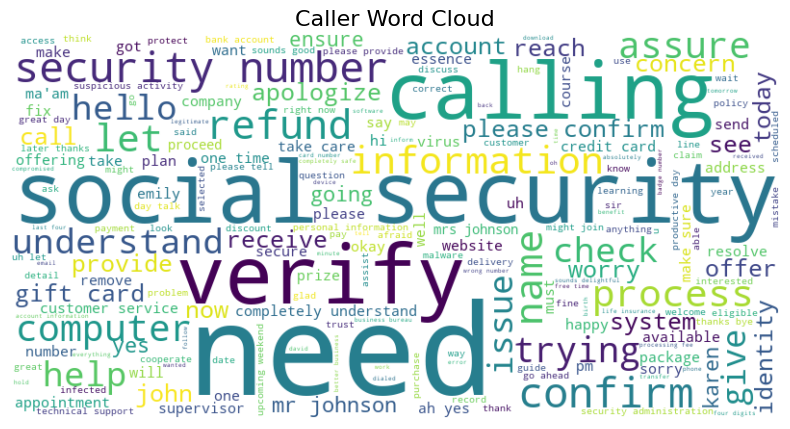

In [15]:
generate_word_cloud(dataset_df["caller_texts"], "Caller Word Cloud")

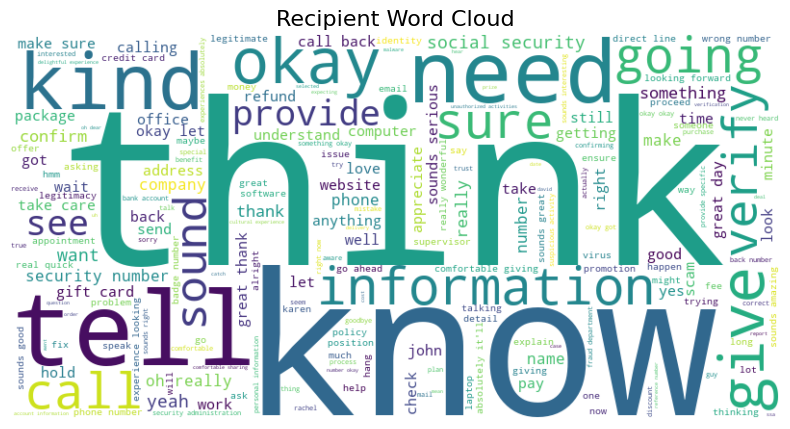

In [16]:
generate_word_cloud(dataset_df["recipient_texts"], "Recipient Word Cloud")

### Most frequently used words for both caller and recipient (Unigram)

The N-gram, is a measure of a sequence of tokens. For example, a 1-gram or unigram is a sequence containing 1 token.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(text_series, top_k=10):
    """
    Identifies the most frequently used words in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top words to extract.
    
    Returns:
        List of tuples: Top words and their counts.
    """
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(text_series.dropna())
    word_freq = word_counts.sum(axis=0).A1
    word_features = vectorizer.get_feature_names_out()
    top_words = sorted(zip(word_features, word_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_words

In [18]:
import matplotlib.pyplot as plt

def plot_top_words(word_freq, title):
    """
    Plots the top words with their frequencies as a bar chart.
    
    Args:
        word_freq (list of tuples): List of words and their counts.
        title (str): Title of the plot.
    """
    words, counts = zip(*word_freq)  # Unpack words and counts
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color="skyblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Words", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

#### Top Caller Words

In [19]:
top_caller_words = get_top_words(dataset_df["caller_texts"], top_k=10)
print("Top Caller Words:", top_caller_words)

Top Caller Words: [('you', 50392), ('to', 42350), ('the', 32172), ('your', 28584), ('and', 27786), ('we', 22173), ('it', 17078), ('is', 16429), ('can', 15845), ('that', 14053)]


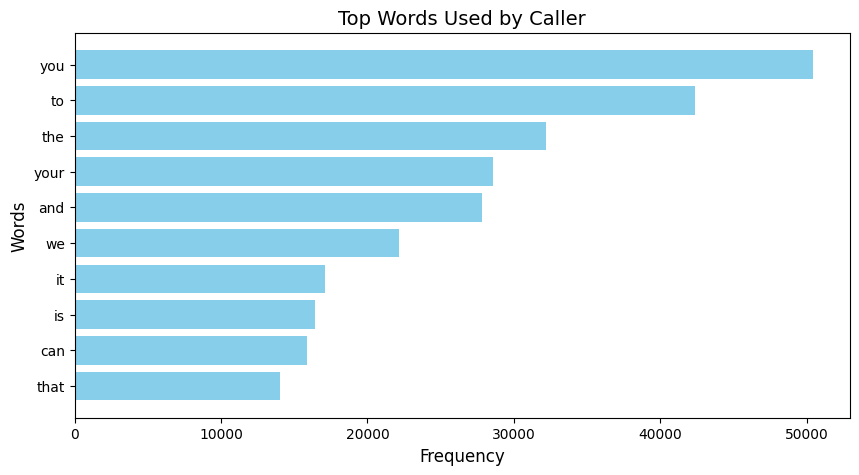

In [20]:
plot_top_words(top_caller_words, "Top Words Used by Caller")

#### Top Recipient Words

In [21]:
top_recipient_words = get_top_words(dataset_df["recipient_texts"], top_k=10)
print("Top Recipient Words:", top_recipient_words)

Top Recipient Words: [('you', 30002), ('to', 18524), ('the', 15515), ('that', 14800), ('can', 14279), ('me', 11969), ('it', 11378), ('what', 11168), ('and', 10210), ('my', 8957)]


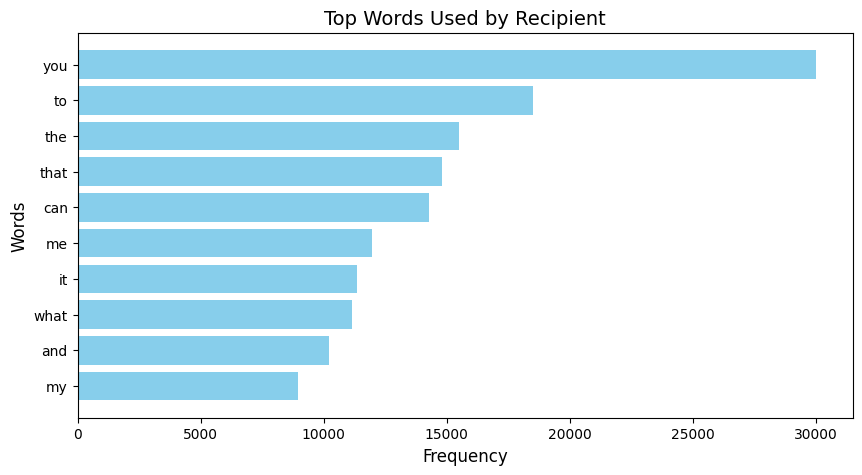

In [22]:
plot_top_words(top_recipient_words, "Top Words Used by Recipient")

### Most frequent bi-grams and tri-grams

This focuses on phrase-level granularity

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to get top n-grams
def get_top_ngrams(text_series, n, top_k=10):
    """
    Identifies the most frequently used n-grams in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        n (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
        top_k (int): Number of top n-grams to extract.
    
    Returns:
        List of tuples: Top n-grams and their counts.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_counts = vectorizer.fit_transform(text_series.dropna())
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngram_features, ngram_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_ngrams

# Function to plot n-grams
def plot_top_ngrams(ngrams, title):
    """
    Plots the top n-grams with their frequencies as a bar chart.
    
    Args:
        ngrams (list of tuples): List of n-grams and their counts.
        title (str): Title of the plot.
    """
    ngram_labels, ngram_counts = zip(*ngrams)  # Unpack n-grams and counts
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color="lightblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("N-Grams", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

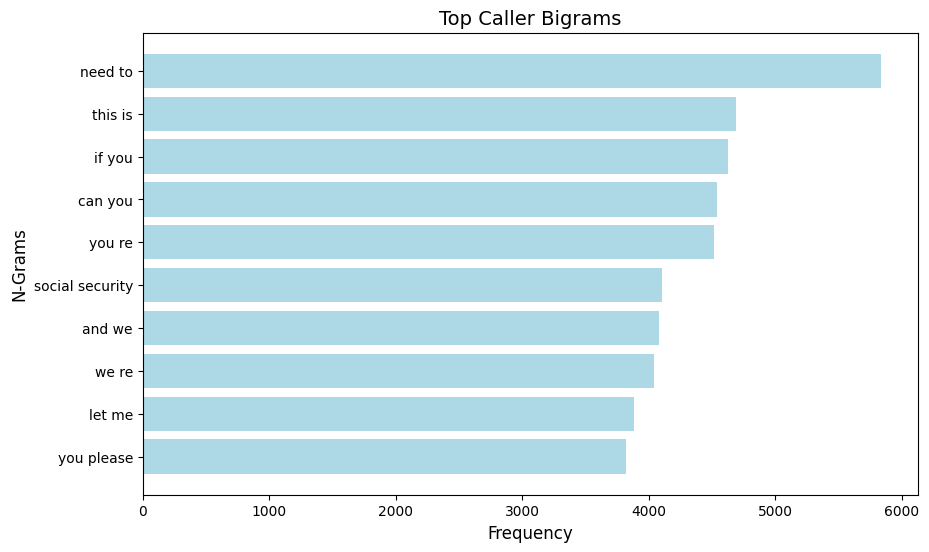

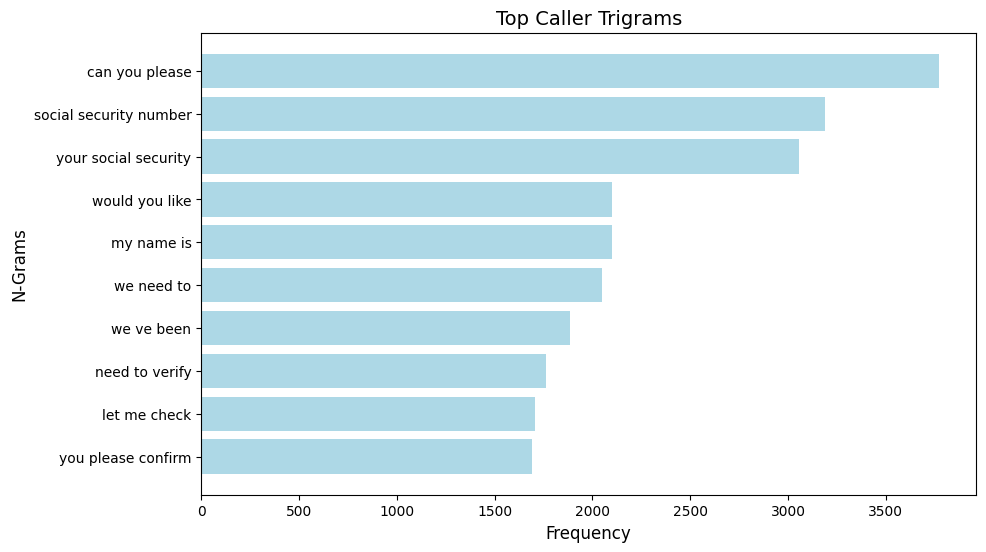

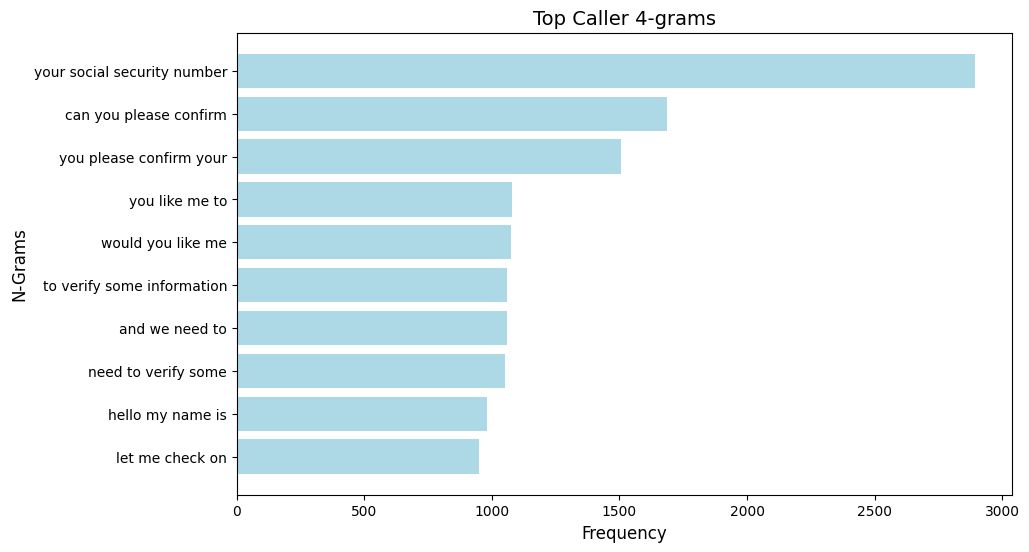

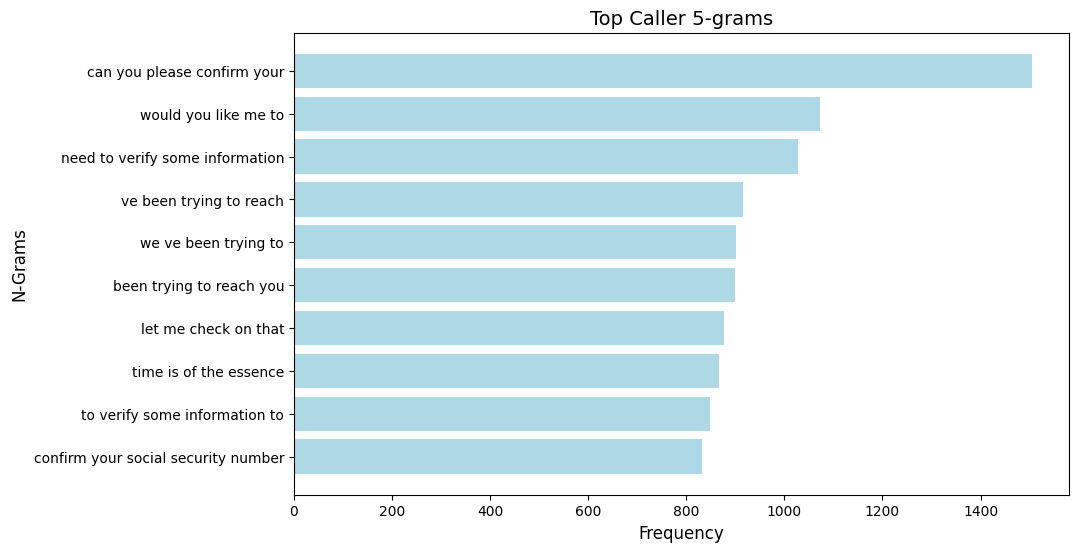

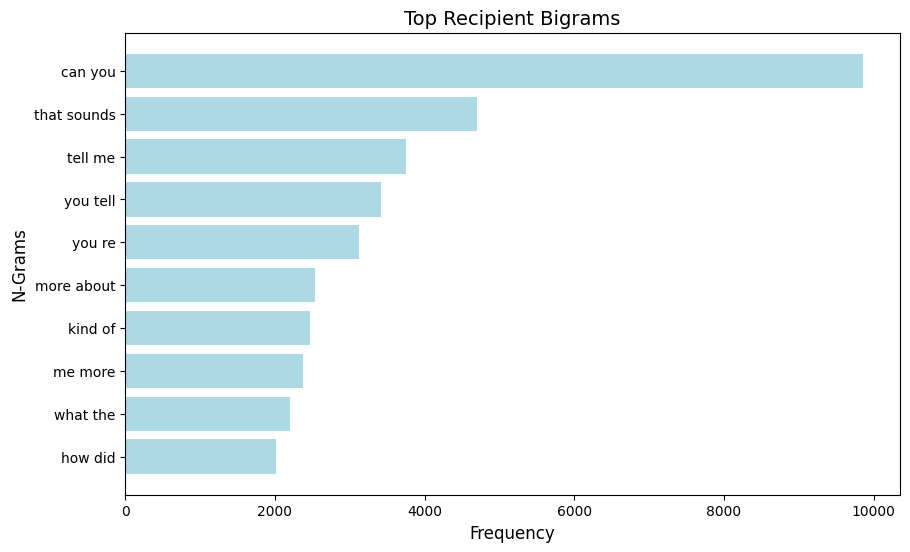

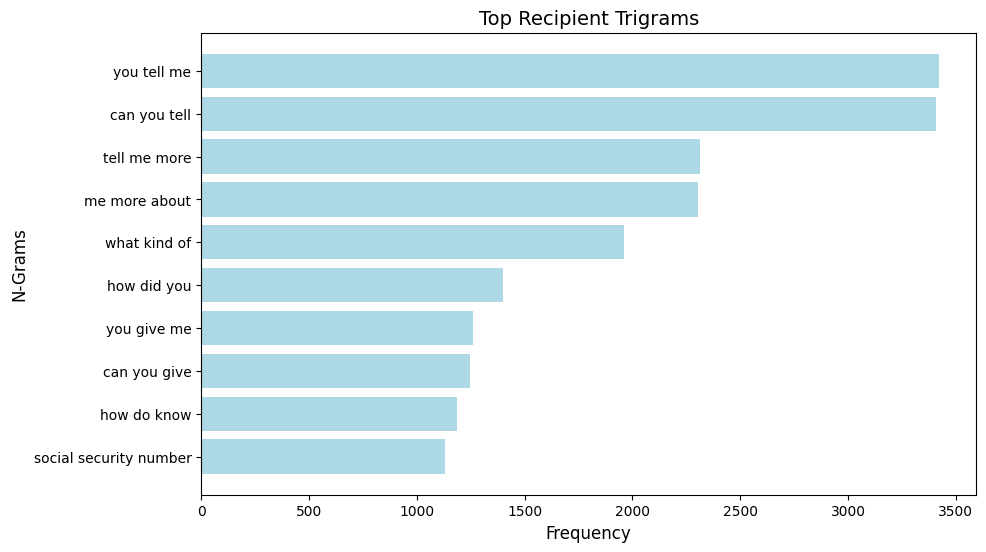

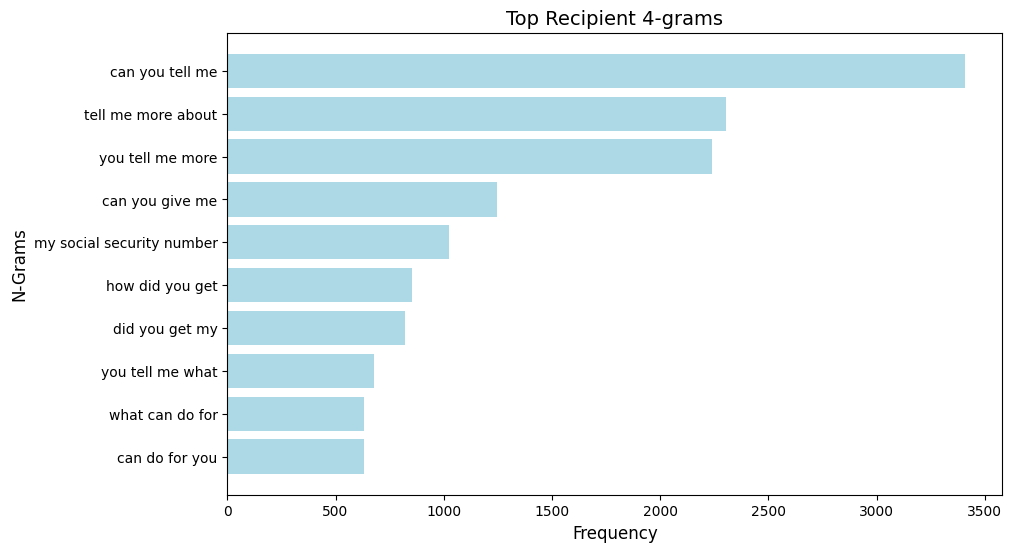

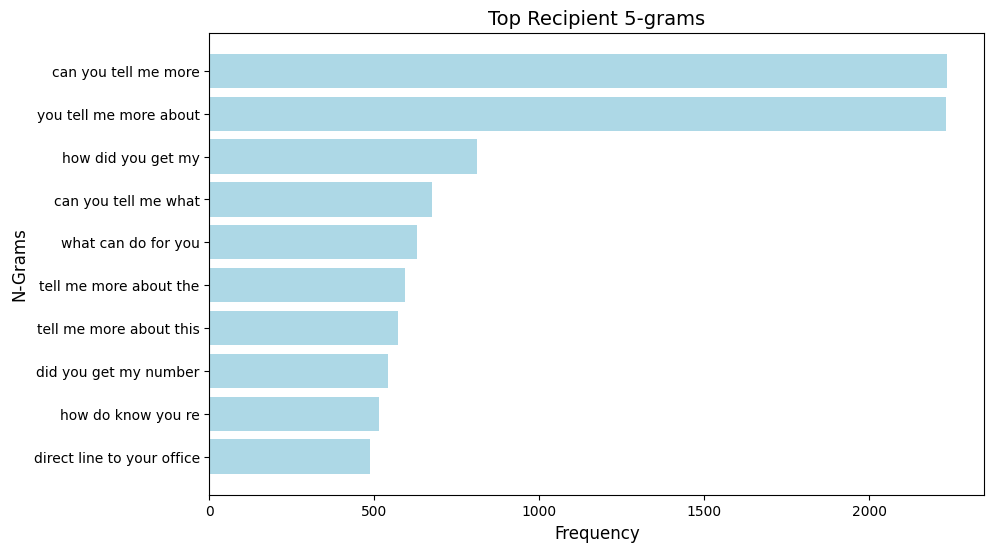

In [24]:
# Replace with your dataset's caller and recipient texts
caller_texts = dataset_df["caller_texts"]  # Ensure this contains the extracted caller texts
recipient_texts = dataset_df["recipient_texts"]  # Ensure this contains the extracted recipient texts

# Generate Bigrams and Trigrams
top_caller_bigrams = get_top_ngrams(caller_texts, n=2, top_k=10)
top_caller_trigrams = get_top_ngrams(caller_texts, n=3, top_k=10)
top_caller_4grams = get_top_ngrams(caller_texts, n=4, top_k=10)
top_caller_pentagrams = get_top_ngrams(caller_texts, n=5, top_k=10)

top_recipient_bigrams = get_top_ngrams(recipient_texts, n=2, top_k=10)
top_recipient_trigrams = get_top_ngrams(recipient_texts, n=3, top_k=10)
top_recipient_4grams = get_top_ngrams(recipient_texts, n=4, top_k=10)
top_recipient_pentagrams = get_top_ngrams(recipient_texts, n=5, top_k=10)
 
# Plot Bigrams and Trigrams for Caller and Recipient
plot_top_ngrams(top_caller_bigrams, "Top Caller Bigrams")
plot_top_ngrams(top_caller_trigrams, "Top Caller Trigrams")
plot_top_ngrams(top_caller_4grams, "Top Caller 4-grams")
plot_top_ngrams(top_caller_pentagrams, "Top Caller 5-grams")
plot_top_ngrams(top_recipient_bigrams, "Top Recipient Bigrams")
plot_top_ngrams(top_recipient_trigrams, "Top Recipient Trigrams")
plot_top_ngrams(top_recipient_4grams, "Top Recipient 4-grams")
plot_top_ngrams(top_recipient_pentagrams, "Top Recipient 5-grams")

#### Recipient's 5-Grams
#### 1. Questions Indicating Clarification or Doubt
- Recipients frequently use phrases like:
  - *"can you tell me more"*
  - *"you tell me more about"*
  - *"how did you get my"*
- These phrases indicate skepticism or curiosity, as recipients often seek clarification or details about the caller's intentions.

#### 2. Focus on Specific Information
- Common phrases include:
  - *"what can do for you"*
  - *"tell me more about the"*
- These patterns suggest that recipients try to gather additional context before making decisions.

#### 3. Skepticism and Inquiry
- Phrases such as:
  - *"how did you get my number"*
  - *"how do know you re"*
- Reflect distrust and a questioning attitude, which are common responses to suspicious calls.

---

#### Caller's 5-Grams
#### 1. Authority and Urgency
- Callers frequently use phrases like:
  - *"can you please confirm your"*
  - *"need to verify some information"*
- These phrases aim to establish authority and create a sense of urgency, aligning with typical scam strategies.

#### 2. Persistence in Communication
- Repeated attempts to contact the recipient are evident in phrases such as:
  - *"we ve been trying to"*
  - *"been trying to reach you"*
- These patterns suggest callers create a narrative of missed communication to pressure recipients into responding.

#### 3. Direct Requests for PII
- Explicit requests for sensitive information are common, as seen in:
  - *"confirm your social security number"*
- These phrases indicate an attempt to extract PII (Personally Identifiable Information), a strong hallmark of scams.

#### 4. Manipulative Language
- Callers use manipulative phrases like:
  - *"time is of the essence"*
- This reflects tactics designed to rush recipients into decisions without careful consideration.

---

#### Comparative Observations
- **Recipient's Behavior**:
  - Recipients focus on clarifying and verifying information.
  - Their responses show skepticism and are inquiry-driven.
- **Caller's Behavior**:
  - Callers use urgency, authority, and persistence to elicit compliance.
  - They frequently make direct requests for sensitive information or actions.

---

#### Conclusion for N-Gram Analysis
- The plots highlight contrasting linguistic strategies:
  - **Recipients**: Seek clarification and express skepticism to protect themselves.
  - **Callers**: Employ authority, urgency, and manipulative language to pressure recipients into compliance.
- These insights can guide feature engineering for the scam detection model, emphasizing linguistic patterns and intent.

### Extract Top Nouns

In [25]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Download SpaCy's English model
spacy.cli.download("en_core_web_sm")

# Enable GPU (if available)
print("GPU Enabled:", spacy.prefer_gpu())

# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm")

def extract_top_nouns(text_series, top_k=10):
    """
    Extracts the top nouns from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top nouns to extract.
    
    Returns:
        List of tuples: Top nouns and their counts.
    """
    all_nouns = []
    
    # Iterate through each text entry
    for text in text_series.dropna():
        doc = nlp(text)  # SpaCy's NLP pipeline
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
        all_nouns.extend(nouns)
    
    # Count noun frequencies
    noun_counts = Counter(all_nouns)
    return noun_counts.most_common(top_k)

def plot_top_nouns(noun_counts, title):
    """
    Plots the top nouns with their frequencies as a bar chart.
    
    Args:
        noun_counts (list of tuples): List of nouns and their counts.
        title (str): Title of the plot.
    """
    nouns, counts = zip(*noun_counts)  # Unpack nouns and counts
    plt.figure(figsize=(10, 6))
    plt.barh(nouns, counts, color="coral")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Nouns", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.8 MB/s eta 0:00:0000:0100:01



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
GPU Enabled: True


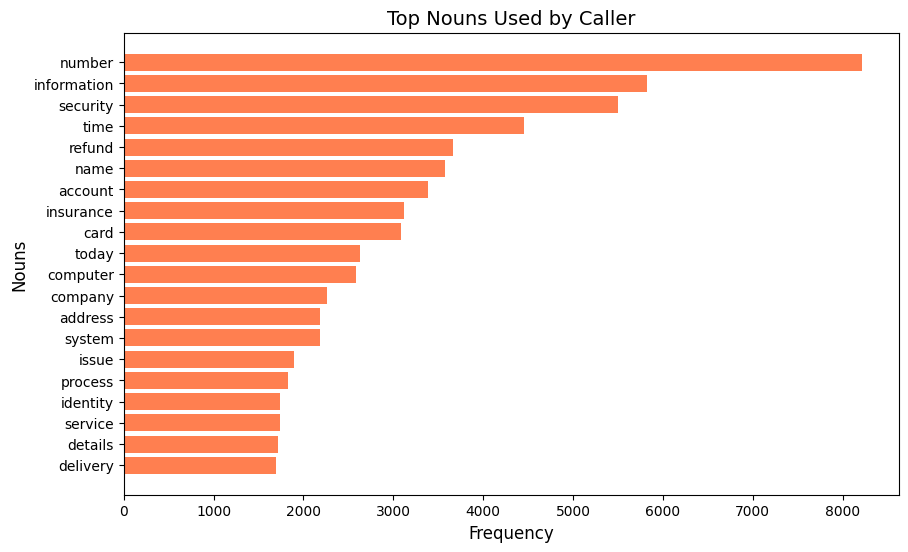

In [26]:
top_caller_nouns = extract_top_nouns(dataset_df["caller_texts"], top_k=20)
plot_top_nouns(top_caller_nouns, "Top Nouns Used by Caller")

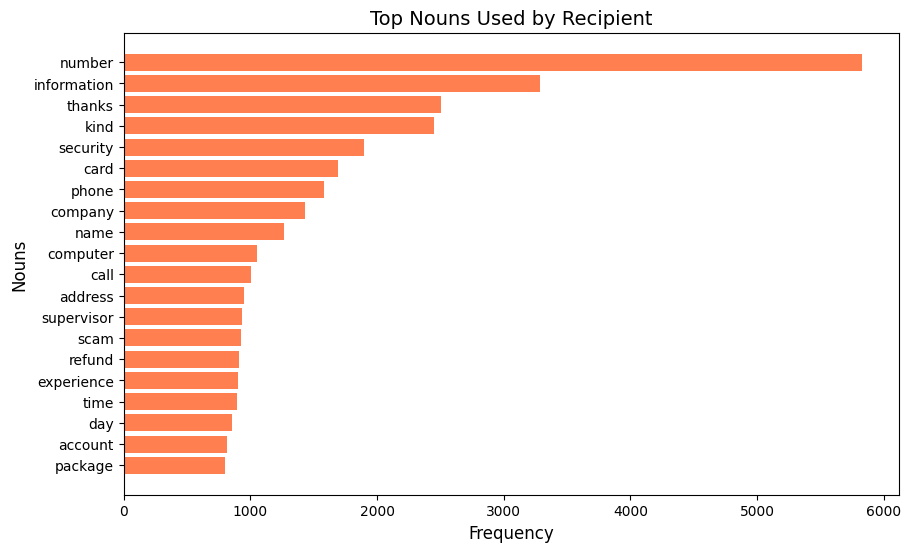

In [27]:
top_recipient_nouns = extract_top_nouns(dataset_df["recipient_texts"], top_k=20)
plot_top_nouns(top_recipient_nouns, "Top Nouns Used by Recipient")

Not much of a difference can be seen between the top nouns used by the caller's and recipients.

## 3. Feature Extraction and Engineering

### A summary of the dataset

Now, the dataset comprises of the following columns:

1. `dialogue` - The original combined phone call conversation
2. `labels` - Represents whether or not the conversation is likely (1) or unlikely (0) a scam call
3. `type` - The type/category of scam
4. `dialogue_processed` - The processed dialogue with the caller/recipient tag standardised
5. `caller_texts` - Only the caller's transcription derived from `dialogue_processed`
6. `recipient_texts` - The recipient's transcription derived from `dialogue_processed`

In [28]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed,caller_texts,recipient_texts
0,"caller: hi, this is karen from dr. smith's off...",0,appointment,"caller: hi, karen dr. smith's office. calling ...","hi, this is karen from dr. smith's office. i'm...","oh, hi karen. i think there might be some mist..."
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment,"caller: hi, john? recipient: yeah, that's me. ...","hi, is this john? this is karen from dr. smith...","yeah, that's me. who's this? ah, yeah. i think..."
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment,"caller: hi, calling xyz medical center. schedu...","hi, i'm calling from xyz medical center. we ha...","actually, i'm not sure. can you tell me what t..."
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment,"caller: hi, calling confirm appointment tomorr...","hi, i'm calling to confirm your appointment fo...","oh, i don't recall scheduling an appointment. ..."
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment,"caller: hi, calling dr. smith's office. schedu...","hi, i'm calling from dr. smith's office. we ha...","actually, i don't recall making an appointment..."


### Extract the 5-grams from both caller and recipient

From the EDA process, we understand that the 5-grams from both the caller and the recipient provide the most insights on the top phrases and words. We will now extract the 5-grams on a row basis for both the caller and recipient, and then vectorize them using scikit-learn's `CountVectorizer()`.
For now, we will set `max_features` to 5000, which only considers the top 5000 5-grams for each. If this parameter is not set, the number of features can span in the hundreds of thousands!

In [29]:
caller_vectorizer = CountVectorizer(ngram_range=(5, 5), max_features=5000)
recipient_vectorizer = CountVectorizer(ngram_range=(5, 5), max_features=5000)

### What is the `CountVectorizer()`?

The `CountVectorizer()` class is instantiated for both the caller and the recipient. The constructor argument `ngram_range(5, 5)` represents the sequence count to take note of, in this case - a sequence length of 5 tokens. After passing an item in `caller_texts` into the `CountVectorizer()`, the vectorizer converts it into a sparse matrix, with each row representing a row in our original dataset, whereas each column represents the occurrence of the n-gram.

For example, if "Can you please confirm your" is uttered twice by the caller, it would be a matrix like [[2, 0, 0, ..., 0]].

In [30]:
X_caller = caller_vectorizer.fit_transform(dataset_df["caller_texts"])
X_recipient = recipient_vectorizer.fit_transform(dataset_df["recipient_texts"])

### Concatenate both the caller and recipient matrices

Example:

Caller -> (1000, 5000)

Recipient -> (1000, 4000)

Combined -> (1000, 9000)

In [31]:
from scipy.sparse import hstack

X_combined = hstack([X_caller, X_recipient])

In [32]:
X_combined.shape

(5820, 10000)

### TF-IDF Embeddings

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical representation of text that reflects how important a word is in a document relative to a collection of documents. Unlike Word2Vec, which captures contextual meaning, **TF-IDF focuses on word frequency and uniqueness**.

#### How is it used?

1. **Initialize TF-IDF Vectorizer**  
   - `TfidfVectorizer(max_features=5000)` creates a **vector representation** of text.
   - `max_features=5000` limits the vocabulary to the **top 5000 most important words**.

2. **Compute TF-IDF Embeddings**  
   - `fit_transform()` processes and **vectorizes** `caller_texts` and `recipient_texts`.
   - This converts each text into a **sparse matrix** where each column represents a unique word.


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Compute TF-IDF embeddings
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_caller_tfidf = tfidf_vectorizer.fit_transform(dataset_df["caller_texts"])
X_recipient_tfidf = tfidf_vectorizer.fit_transform(dataset_df["recipient_texts"])

# Combine caller and recipient TF-IDF embeddings and check the shape
X_combined = hstack([X_caller_tfidf, X_recipient_tfidf])
X_combined.shape

(5820, 9976)

### Word2Vec Embeddings

Word2Vec is a **word embedding technique** that maps words into vector space, capturing semantic meanings based on their context. Unlike TF-IDF, which treats words independently, Word2Vec considers the relationship between words in a sentence.

#### How is it used?

1. **Tokenization**  
   - Text is split into individual words using `.str.split()`.
   - Both `caller_texts` and `recipient_texts` are tokenized separately.

2. **Training the Word2Vec Model**  
   - The `Word2Vec` model is trained on the **combined caller and recipient tokenized texts**.
   - Key parameters:
     - `vector_size=100` → Each word is represented as a **100-dimensional vector**.
     - `window=5` → The model looks at **5 words** before and after a target word for context.
     - `min_count=2` → Words appearing **fewer than 2 times** are ignored.
     - `workers=4` → Uses **4 CPU threads** for parallel training.

3. **Generating Sentence Embeddings**  
   - The **[average of word vectors]** in a sentence is used as the **sentence embedding**.
   - If a word is **not in the vocabulary**, it is skipped.


In [34]:
import numpy as np
from gensim.models import Word2Vec
# take note: gensim requires numpy 1.26.4, scipy 1.13.1 to work

# Tokenize text by splitting into words
dataset_df["caller_tokens"] = dataset_df["caller_texts"].str.split()
dataset_df["recipient_tokens"] = dataset_df["recipient_texts"].str.split()

# Train Word2Vec model on combined caller and recipient tokens
w2v_model = Word2Vec(sentences=dataset_df["caller_tokens"].tolist() + dataset_df["recipient_tokens"].tolist(),
                      vector_size=100, window=5, min_count=2, workers=4)

# Function to compute sentence embeddings by averaging word vectors
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Compute Word2Vec embeddings for caller and recipient texts
X_caller_w2v = np.vstack(dataset_df["caller_tokens"].apply(lambda x: get_sentence_embedding(x, w2v_model)))
X_recipient_w2v = np.vstack(dataset_df["recipient_tokens"].apply(lambda x: get_sentence_embedding(x, w2v_model)))

# Ensure both arrays are 2D
X_caller_w2v = X_caller_w2v.reshape(X_caller_w2v.shape[0], -1)
X_recipient_w2v = X_recipient_w2v.reshape(X_recipient_w2v.shape[0], -1)

# Combine caller and recipient TF-IDF embeddings and check the shape
X_combined = np.hstack([X_caller_w2v, X_recipient_w2v])
X_combined.shape

(5820, 200)

### BERT Embeddings with DistilBERT

DistilBERT (a distilled version of BERT) is a **smaller, faster, and more efficient** transformer model that retains 97% of BERT's performance while being 60% faster. It generates **context-aware embeddings** by analyzing a word in relation to its surrounding words, improving upon traditional models like TF-IDF and Word2Vec.

#### How is it used?

1. **Device Selection**  
   - Automatically selects **GPU** if available, otherwise defaults to **CPU** for processing.

2. **Tokenization**  
   - Converts text into **numerical tokens** using `DistilBertTokenizer`, ensuring proper handling of text structure.

3. **Model Inference**  
   - A `DistilBertModel` processes tokenized text and extracts **contextual embeddings**.
   - The **[CLS] token** (first token in the sequence) is used as the **sentence representation**.

4. **Batch Processing**  
   - Text data is processed in **batches of 32** to optimize speed and memory usage.
   - Each batch is tokenized, passed through the model, and converted into embeddings.


In [35]:
import torch
import numpy as np
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel


# Automatically select the best device (GPU, MPS, or CPU) at runtime
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps") # Apple Metal Performance Shaders (MPS) device
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Load BERT tokenizer and model once and move model to the selected device
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()  # Disable dropout layers for efficiency

def fit_transform_bert(text_series, batch_size=32):
    """
    Fit and transform text data into BERT embeddings.

    Parameters:
    - text_series (pd.Series or list): Input text data.
    - batch_size (int): Number of texts to process at once.

    Returns:
    - np.array: Numpy array of BERT sentence embeddings.
    """
    text_list = text_series.fillna("").astype(str).tolist()
    all_embeddings = []

    # Process text data in batches
    for i in tqdm(range(0, len(text_list), batch_size), desc=f"Processing BERT Embeddings on {device}"):
        batch_texts = text_list[i:i+batch_size]
        batch_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = bert_model(**batch_inputs)  # Compute embeddings

        # Extract CLS token embeddings
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)

# Fit and transform caller texts
X_caller = fit_transform_bert(dataset_df["caller_texts"], batch_size=32)

# Fit and transform recipient texts
X_recipient = fit_transform_bert(dataset_df["recipient_texts"], batch_size=32)

# Combine caller and recipient matrices and display shape
X_combined = np.hstack([X_caller, X_recipient])
print("Final shape:", X_combined.shape)


/Users/choonkeatling/INF2008_P1-08/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


Processing BERT Embeddings on mps: 100%|██████████| 182/182 [02:01<00:00,  1.50it/s]

Final shape: (5820, 1536)


In [36]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed,caller_texts,recipient_texts,caller_tokens,recipient_tokens
0,"caller: hi, this is karen from dr. smith's off...",0,appointment,"caller: hi, karen dr. smith's office. calling ...","hi, this is karen from dr. smith's office. i'm...","oh, hi karen. i think there might be some mist...","[hi,, this, is, karen, from, dr., smith's, off...","[oh,, hi, karen., i, think, there, might, be, ..."
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment,"caller: hi, john? recipient: yeah, that's me. ...","hi, is this john? this is karen from dr. smith...","yeah, that's me. who's this? ah, yeah. i think...","[hi,, is, this, john?, this, is, karen, from, ...","[yeah,, that's, me., who's, this?, ah,, yeah.,..."
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment,"caller: hi, calling xyz medical center. schedu...","hi, i'm calling from xyz medical center. we ha...","actually, i'm not sure. can you tell me what t...","[hi,, i'm, calling, from, xyz, medical, center...","[actually,, i'm, not, sure., can, you, tell, m..."
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment,"caller: hi, calling confirm appointment tomorr...","hi, i'm calling to confirm your appointment fo...","oh, i don't recall scheduling an appointment. ...","[hi,, i'm, calling, to, confirm, your, appoint...","[oh,, i, don't, recall, scheduling, an, appoin..."
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment,"caller: hi, calling dr. smith's office. schedu...","hi, i'm calling from dr. smith's office. we ha...","actually, i don't recall making an appointment...","[hi,, i'm, calling, from, dr., smith's, office...","[actually,, i, don't, recall, making, an, appo..."


## 4. Model Training and Evaluation (Logistic Regression)

### Convert the labels to a multi-hot encoding

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
type_encoded = le.fit_transform(dataset_df["type"])  # Now each type is a unique int
num_types = len(le.classes_)  # Number of unique types
print("Encoded Types:", type_encoded)

Encoded Types: [1 1 1 ... 0 0 0]


### Split the dataset in train, validation, and test

1. X: The features (BERT embeddings)
2. label(y1): The target variable (labels)
3. type(y2): The type/category of scam

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X_combined, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42)
X_val, X_test, y1_val, y1_test, y2_val, y2_test = train_test_split(X_test, y1_test, y2_test, test_size=0.5, random_state=42)

### Validating class distribution of the validation set

In [39]:
print("Label:\n", pd.Series(y1_val).value_counts())
print("\n")
print("Type:\n", pd.Series(y2_val).value_counts())

Label:
 labels
1    898
0    848
Name: count, dtype: int64


Type:
 7     197
9     196
3     187
6     184
4     184
11    176
8     174
0     148
1     116
2     111
10     61
5      12
Name: count, dtype: int64


As you can see, the class distribution is fairly balanced in the validation set.

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class LogisticRegressionModel:
    """
    A logistic regression model wrapper that supports both binary and multi-class classification.
    
    This class uses either a One-vs-Rest classifier with logistic regression or SVC for multi-class tasks,
    and falls back to standard logistic regression for binary classification with only one unique label in y_train.
    
    Attributes:
        model: A fitted classifier (either OneVsRestClassifier wrapping LogisticRegression or SVC, or LogisticRegression).
    """
    
    def __init__(self, X_train, y_train, multi_class_func='logistic'):
        """
        Initializes and fits the classifier on training data.
        
        Parameters:
            X_train (array-like): Training features.
            y_train (array-like): Training labels.
            multi_class_func (str): Determines which classifier to use for multi-class problems.
                                    'logistic' uses LogisticRegression, any other value uses SVC.
        """
        if len(np.unique(y_train)) >= 2:
            if multi_class_func == 'logistic':
                self.model = OneVsRestClassifier(LogisticRegression())
            else:
                self.model = OneVsRestClassifier(SVC())
        else:
            self.model = LogisticRegression()
        
        self.model.fit(X_train, y_train)

    def predict(self, X):
        """
        Predicts the labels for the given input data.
        
        Parameters:
            X (array-like): Input features for which predictions are to be made.
        
        Returns:
            array-like: Predicted labels.
        """
        return self.model.predict(X)

    def evaluate(self, X, y):
        """
        Evaluates the model on the provided dataset and computes various performance metrics.
        
        For multi-class problems (more than 2 classes), metrics are computed using a 'weighted' average.
        For binary classification, a 'binary' average is used.
        
        Parameters:
            X (array-like): Input features.
            y (array-like): True labels.
        
        Returns:
            tuple: A tuple containing:
                - accuracy (float): Overall accuracy of the model.
                - precision (float): Precision score.
                - recall (float): Recall score.
                - f1 (float): F1 score.
                - conf_matrix (array-like): Confusion matrix.
                - class_report (str): Text summary of the precision, recall, and f1-score for each class.
        """
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        
        # Determine averaging method based on the number of classes
        if len(np.unique(y)) > 2:
            average_type = 'weighted'
        else:
            average_type = 'binary'
        
        precision = precision_score(y, y_pred, average=average_type, zero_division=0)
        recall = recall_score(y, y_pred, average=average_type, zero_division=0)
        f1 = f1_score(y, y_pred, average=average_type, zero_division=0)
        
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred)
        
        return accuracy, precision, recall, f1, conf_matrix, class_report

    def plot_confusion_matrix(self, X, y, labels, normalize=False):
        """
        Plots the confusion matrix for the model's predictions.
        
        Optionally, the confusion matrix can be normalized to show proportions instead of raw counts.
        
        Parameters:
            X (array-like): Input features.
            y (array-like): True labels.
            labels (list): List of label names to be used in the plot axes.
            normalize (bool): If True, normalize the confusion matrix by dividing by the sum of each row.
        """
        y_pred = self.predict(X)
        conf_matrix = confusion_matrix(y, y_pred)
        
        # Normalize the confusion matrix if requested
        if normalize:
            conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
            fmt = ".2f"
            title = "Normalized Confusion Matrix"
        else:
            fmt = "d"
            title = "Confusion Matrix"
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(title)
        plt.show()


### Logistic regression results on the validation set

Metrics:

1. Accuracy: *How many total predictions were correct?*
2. Precision: *Out of all predicted scams, how many were actual scams?*
3. Recall: *Out of all actual scams, how many of them were detected?*
4. F1-score: *A balance of precision and recall*
5. Confusion Matrix: *Visual breakdown of the True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)*

In [41]:
y1_logistic_model = LogisticRegressionModel(X_train, y1_train)
y2_logistic_model = LogisticRegressionModel(X_train, y2_train)

y1_accuracy, y1_precision, y1_recall, y1_f1, y1_conf_matrix, y1_class_report = y1_logistic_model.evaluate(X_val, y1_val)

print(f"Validation Set Metrics:\n")
print(f"Accuracy: {y1_accuracy:.4f}")
print(f"Precision: {y1_precision:.4f}")
print(f"Recall: {y1_recall:.4f}")
print(f"F1 Score: {y1_f1:.4f}")
print("\nClassification Report:")
print(y1_class_report)

y2_accuracy, y2_precision, y2_recall, y2_f1, y2_conf_matrix, y2_class_report = y2_logistic_model.evaluate(X_val, y2_val)

print(f"Validation Set Metrics:\n")
print(f"Accuracy: {y2_accuracy:.4f}")
print(f"Precision: {y2_precision:.4f}")
print(f"Recall: {y2_recall:.4f}")
print(f"F1 Score: {y2_f1:.4f}")
print("\nClassification Report:")
print(y2_class_report)

Validation Set Metrics:

Accuracy: 0.9983
Precision: 0.9989
Recall: 0.9978
F1 Score: 0.9983

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       848
           1       1.00      1.00      1.00       898

    accuracy                           1.00      1746
   macro avg       1.00      1.00      1.00      1746
weighted avg       1.00      1.00      1.00      1746

Validation Set Metrics:

Accuracy: 0.9754
Precision: 0.9751
Recall: 0.9754
F1 Score: 0.9744

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       116
           2       0.95      0.98      0.96       111
           3       0.99      1.00      1.00       187
           4       0.92      0.96      0.94       184
           5       0.67      0.50      0.57        12
           6       1.00      0.97      0.98       184
        

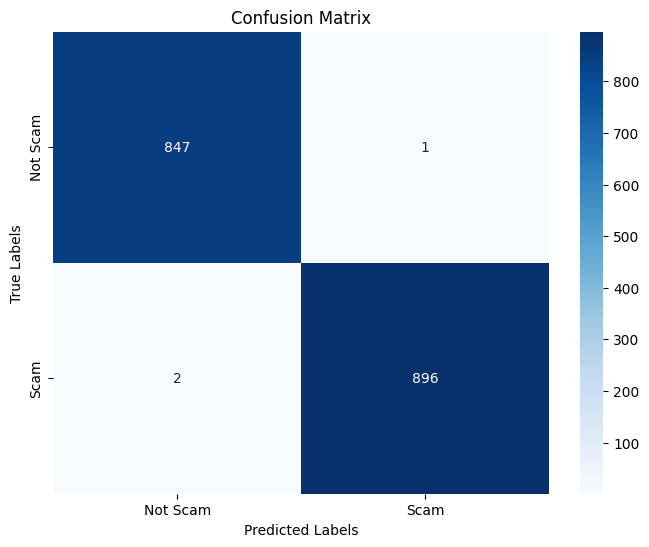

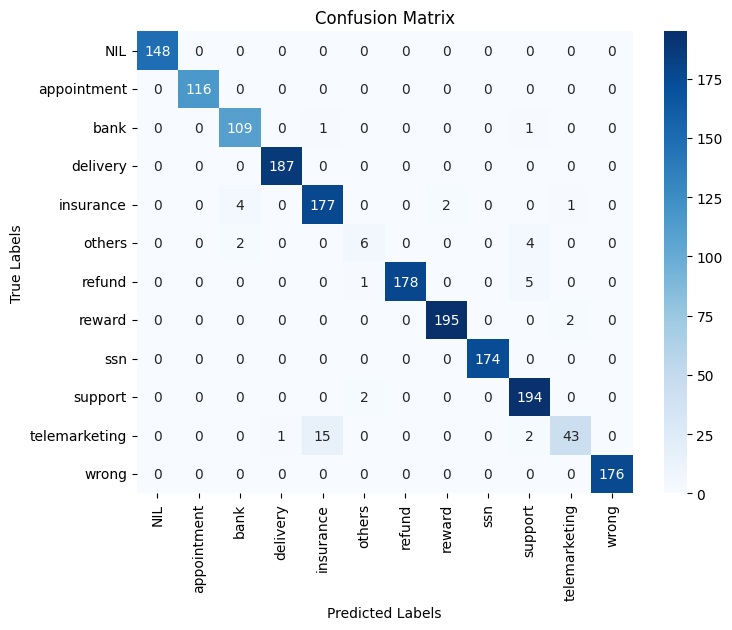

In [42]:
y1_logistic_model.plot_confusion_matrix(X_val, y1_val, ["Not Scam", "Scam"])

y2_logistic_model.plot_confusion_matrix(X_val, y2_val, le.classes_)

### Logistic Regression on the test set

Validating class distribution on the test set. As seen below, they are almost evenly distributed.

In [43]:
print("Label:\n", pd.Series(y1_test).value_counts())
print("\n")
print("Type:\n", pd.Series(y2_test).value_counts())

Label:
 labels
0    881
1    865
Name: count, dtype: int64


Type:
 4     214
3     191
11    184
8     184
6     183
7     179
9     177
0     133
2     120
1     119
10     57
5       5
Name: count, dtype: int64


Test Set Metrics:

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       881
           1       1.00      1.00      1.00       865

    accuracy                           1.00      1746
   macro avg       1.00      1.00      1.00      1746
weighted avg       1.00      1.00      1.00      1746



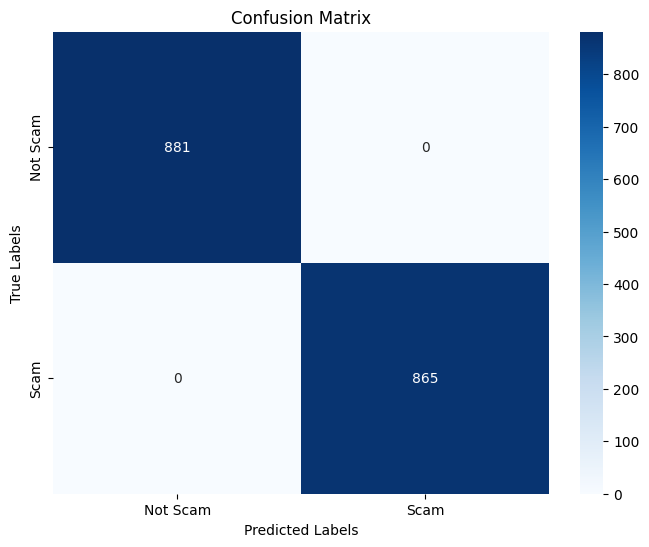

Test Set Metrics:

Accuracy: 0.9788
Precision: 0.9791
Recall: 0.9788
F1 Score: 0.9784

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      0.98      0.99       119
           2       0.94      1.00      0.97       120
           3       0.99      1.00      1.00       191
           4       0.93      0.98      0.95       214
           5       0.60      0.60      0.60         5
           6       0.99      0.97      0.98       183
           7       0.99      0.98      0.99       179
           8       0.99      0.99      0.99       184
           9       0.97      0.98      0.97       177
          10       0.96      0.75      0.84        57
          11       1.00      1.00      1.00       184

    accuracy                           0.98      1746
   macro avg       0.95      0.94      0.94      1746
weighted avg       0.98      0.98      0.98      1746



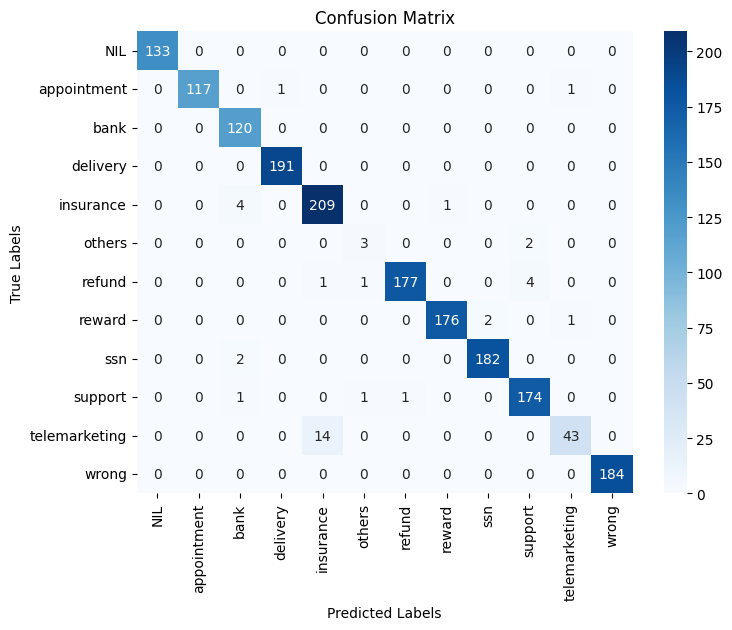

In [44]:
# Make predictions on the test set
y1_test_pred = y1_logistic_model.predict(X_test)
y1_test_accuracy, y1_test_precision, y1_test_recall, y1_test_f1, y1_test_conf_matrix, y1_test_class_report = y1_logistic_model.evaluate(X_test, y1_test)

# Print metrics
print(f"Test Set Metrics:\n")
print(f"Accuracy: {y1_test_accuracy:.4f}")
print(f"Precision: {y1_test_precision:.4f}")
print(f"Recall: {y1_test_recall:.4f}")
print(f"F1 Score: {y1_test_f1:.4f}")
print("\nClassification Report:")
print(y1_test_class_report)

# Plot confusion matrix
y1_logistic_model.plot_confusion_matrix(X_test, y1_test, ["Not Scam", "Scam"])

# Make predictions on the test set
y2_test_pred = y2_logistic_model.predict(X_test)
y2_test_accuracy, y2_test_precision, y2_test_recall, y2_test_f1, y2_test_conf_matrix, y2_test_class_report = y2_logistic_model.evaluate(X_test, y2_test)

# Print metrics
print(f"Test Set Metrics:\n")
print(f"Accuracy: {y2_test_accuracy:.4f}")
print(f"Precision: {y2_test_precision:.4f}")
print(f"Recall: {y2_test_recall:.4f}")
print(f"F1 Score: {y2_test_f1:.4f}")
print("\nClassification Report:")
print(y2_test_class_report)

# Plot confusion matrix
y2_logistic_model.plot_confusion_matrix(X_test, y2_test, le.classes_)

## Model Training and Evaluation (Multi Task Learning)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Custom Dataset Class for Multi-Task Learning
1. **Embedding Features**: BERT embeddings for caller and recipient texts.
2. **Labels**: Binary classification labels for scam detection. Float32 is used here for BCE loss.
3. **Types**: Categorical labels for scam type classification. Int64 is used here for CrossEntropy loss.

In [46]:
class MultiTaskDataset(Dataset):
    def __init__(self, embedding, labels, types):
        self.X = torch.tensor(embedding, dtype=torch.float32)
        # For binary task, we use float labels
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels, dtype=torch.float32)
        # For multi-class, targets should be long (integer encoded)
        self.types = torch.tensor(types.values if hasattr(types, "values") else types, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx], self.types[idx]

### Multi-Task Learning Model Architecture

The model processes input features through shared layers and then splits into two separate heads for different tasks: one for binary classification and another for multi-class classification.

```mermaid
flowchart LR
    input[Input Features] -- 1536(from BERT) --> shared

    subgraph shared[Shared Layers]
        direction TB
        fc1[Linear Layer<br/>in: <br/>] -- 512 --> relu[ReLU] --> dropout[Dropout<br/>p=0.2]
    end

    shared -- 512 --> label_head[Label Head<br/>Linear Layer]
    shared -- 512 --> type_head[Type Head<br/>Linear Layer]

    label_head -- 1 --> label_out[Label Logits<br/>Binary Classification]
    type_head -- 12(from the number_types) --> type_out[Type Logits<br/>Multi-class Classification]
```

In this architecture:

* Shared Layers: Extract features from the input using a linear layer, ReLU, and dropout.
* Binary Head: Produces a single logit for binary classification.
* Multi-class Head: Produces logits for each class in a multi-class setting.

In [47]:
class MultiTaskNet(nn.Module):
    def __init__(self, feature_dimension, num_types):
        super(MultiTaskNet, self).__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(feature_dimension, 512),
            nn.ReLU(),
            nn.Dropout(0.2) # Regularization for preventing overfitting
        )
        # Head for binary scam label prediction
        self.label_head = nn.Linear(512, 1)  # output logit for binary classification
        
        # Head for multi-class scam type prediction
        self.type_head = nn.Linear(512, num_types)
    
    def forward(self, x):
        shared_rep = self.shared(x)
        # For binary classification, we’ll use BCEWithLogitsLoss, so no sigmoid here.
        label_logits = self.label_head(shared_rep)
        # For type classification, output logits (to be used with CrossEntropyLoss)
        type_logits = self.type_head(shared_rep)
        return label_logits, type_logits

### Multi-Task Learning Model

1. **Loss Functions**:
   - **Binary Classification**: Binary Cross-Entropy Loss
   - **Multi-class Classification**: Cross-Entropy Loss
2. **Optimizer**: Adam Optimizer with a default learning rate of 0.001


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class MutltiTaskModel:
    def __init__(self, X_train, y1_train, y2_train, num_types, batch_size=32, lr=1e-3):
        self.model = MultiTaskNet(X_train.shape[1], num_types)

        # Determine device (cuda, mps, or cpu)
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cpu")
        self.model.to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion_label = nn.BCEWithLogitsLoss()
        self.criterion_type = nn.CrossEntropyLoss()
        self.batch_size = batch_size

        # Create DataLoader for training
        self.train_dataset = MultiTaskDataset(X_train, y1_train, y2_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)

        # Lists to store losses for plotting
        self.train_label_losses = []
        self.train_type_losses = []
        
        # For saving the best model
        self.best_model_weights = None

    def train(self, num_epochs):
        best_loss = float('inf')

        for epoch in range(num_epochs):
            self.model.train()
            total_loss_label = 0.0
            total_loss_type = 0.0
            num_batches = 0
            
            for inputs, labels, types in self.train_loader:
                inputs, labels, types = inputs.to(self.device), labels.to(self.device), types.to(self.device)
                
                self.optimizer.zero_grad()
                label_logits, type_logits = self.model(inputs)
                
                loss_label = self.criterion_label(label_logits.view(-1), labels)
                loss_type = self.criterion_type(type_logits, types)
                
                loss = loss_label + loss_type
                loss.backward()
                self.optimizer.step()
                
                total_loss_label += loss_label.item()
                total_loss_type += loss_type.item()
                num_batches += 1
            
            # Calculate average loss for the epoch
            avg_loss_label = total_loss_label / num_batches
            avg_loss_type = total_loss_type / num_batches
            total_loss = avg_loss_label + avg_loss_type
            
            # Store losses for plotting
            self.train_label_losses.append(avg_loss_label)
            self.train_type_losses.append(avg_loss_type)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Average Loss (Label): {avg_loss_label:.4f}")
                print(f"Average Loss (Type): {avg_loss_type:.4f}")
                print(f"Total Loss: {total_loss:.4f}\n")
            
            # Save best model weights
            if total_loss < best_loss:
                best_loss = total_loss
                self.best_model_weights = self.model.state_dict()
                
        print("Training complete.")

    def plot_losses(self):
        """
        Plots the losses for label and type predictions during training.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_label_losses, label="Label Loss")
        plt.plot(self.train_type_losses, label="Type Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Losses")
        plt.legend()
        plt.show()

    def predict(self, X):
        """
        Makes predictions for the given inputs X.
        
        Parameters:
            X (numpy array or tensor): Input features.
        
        Returns:
            tuple: (predicted_label, predicted_type) where predicted_label is the binary prediction (0 or 1)
                   and predicted_type is the predicted class for multi-class task.
        """
        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor(X, dtype=torch.float32).to(self.device)
            label_logits, type_logits = self.model(inputs)
            label_pred = (torch.sigmoid(label_logits) >= 0.5).cpu().numpy().astype(int) # Convert to 0 or 1 instead of floating point from sigmoid
            type_pred = torch.argmax(type_logits, dim=1).cpu().numpy()
        
        return label_pred, type_pred

    def evaluate(self, X, y1, y2):
        """
        Evaluates the model on the provided dataset and computes various performance metrics.
        
        Parameters:
            X (array-like): Input features.
            y1 (array-like): True labels for binary classification.
            y2 (array-like): True labels for multi-class classification.
        
        Returns:
            tuple: A nested tuple containing:
                - accuracy (float): Overall accuracy of the model.
                - precision (float): Precision score.
                - recall (float): Recall score.
                - f1 (float): F1 score.
                - conf_matrix (array-like): Confusion matrix.
                - class_report (str): Text summary of the precision, recall, and f1-score for each class.
        """
        y1_pred, y2_pred = self.predict(X)
        
        # Binary classification metrics
        accuracy_label = accuracy_score(y1, y1_pred)
        precision_label = precision_score(y1, y1_pred, zero_division=0)
        recall_label = recall_score(y1, y1_pred, zero_division=0)
        f1_label = f1_score(y1, y1_pred, zero_division=0)
        conf_matrix_label = confusion_matrix(y1, y1_pred)
        
        # Multi-class classification metrics
        accuracy_type = accuracy_score(y2, y2_pred)
        precision_type = precision_score(y2, y2_pred, average='weighted', zero_division=0)
        recall_type = recall_score(y2, y2_pred, average='weighted', zero_division=0)
        f1_type = f1_score(y2, y2_pred, average='weighted', zero_division=0)
        conf_matrix_type = confusion_matrix(y2, y2_pred)
        
        return (accuracy_label, precision_label, recall_label, f1_label, conf_matrix_label), \
               (accuracy_type, precision_type, recall_type, f1_type, conf_matrix_type)
    
    def plot_confusion_matrix(self, X, y1, y2, labels):
        """
        Plots the confusion matrix for the model's predictions.
        
        Parameters:
            X (array-like): Input features.
            y1 (array-like): True labels for binary classification.
            y2 (array-like): True labels for multi-class classification.
            labels (list): List of label names to be used in the plot axes.
        """
        y1_pred, y2_pred = self.predict(X)
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_matrix(y1, y1_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Scam", "Scam"], yticklabels=["Not Scam", "Scam"])
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Binary Classification")
        
        plt.subplot(1, 2, 2)
        sns.heatmap(confusion_matrix(y2, y2_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Multi-Class Classification")
        
        plt.tight_layout()
        plt.show()




#### Training the Multi-Task Learning Model

- The model is trained for **5 epochs** with a batch size of **32**.
- **Binary Classification** and **Multi-class Classification** losses are computed separately.

In [49]:
multi_task_model = MutltiTaskModel(X_train, y1_train, y2_train, num_types, batch_size=32, lr=1e-3)
multi_task_model.train(100)

Epoch 1/100
Average Loss (Label): 0.2705
Average Loss (Type): 1.1957
Total Loss: 1.4662

Epoch 11/100
Average Loss (Label): 0.0055
Average Loss (Type): 0.0395
Total Loss: 0.0450

Epoch 21/100
Average Loss (Label): 0.0019
Average Loss (Type): 0.0367
Total Loss: 0.0387

Epoch 31/100
Average Loss (Label): 0.0012
Average Loss (Type): 0.0173
Total Loss: 0.0185

Epoch 41/100
Average Loss (Label): 0.0007
Average Loss (Type): 0.0104
Total Loss: 0.0111

Epoch 51/100
Average Loss (Label): 0.0032
Average Loss (Type): 0.0052
Total Loss: 0.0084

Epoch 61/100
Average Loss (Label): 0.0001
Average Loss (Type): 0.0040
Total Loss: 0.0040

Epoch 71/100
Average Loss (Label): 0.0049
Average Loss (Type): 0.0046
Total Loss: 0.0094

Epoch 81/100
Average Loss (Label): 0.0010
Average Loss (Type): 0.0021
Total Loss: 0.0030

Epoch 91/100
Average Loss (Label): 0.0003
Average Loss (Type): 0.0036
Total Loss: 0.0039

Training complete.


### Loss Graphs

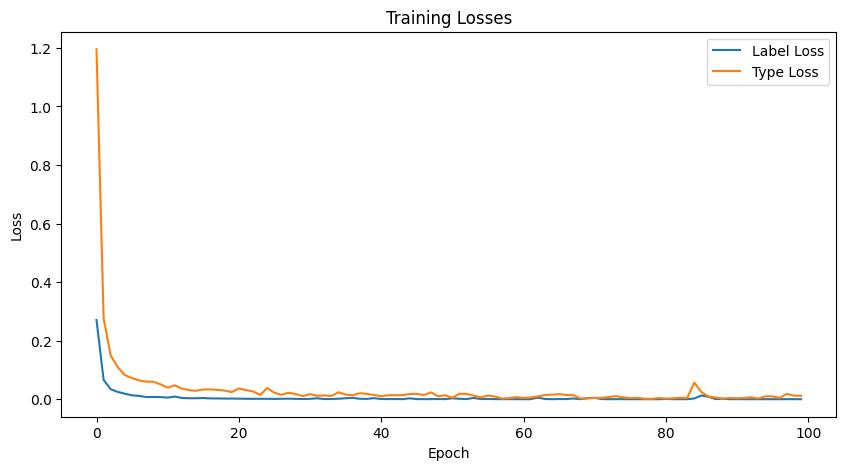

In [50]:
multi_task_model.plot_losses()

### Model Evaluation on the Validation Set

Validation Set Metrics:
Binary Classification:
Accuracy: 0.9983
Precision: 1.0000
Recall: 0.9967
F1 Score: 0.9983

Multi-Class Classification:
Accuracy: 0.9748
Precision: 0.9760
Recall: 0.9748
F1 Score: 0.9748


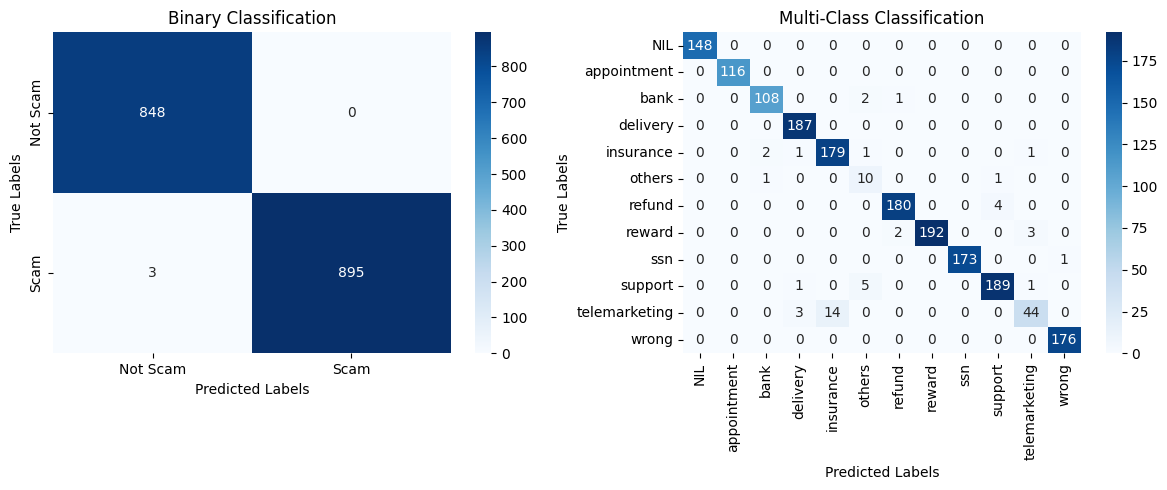

In [51]:
pred_label, pred_type = multi_task_model.predict(X_val)

eval_label, eval_type = multi_task_model.evaluate(X_val, y1_val, y2_val)

print("Validation Set Metrics:")
print(f"Binary Classification:")
print(f"Accuracy: {eval_label[0]:.4f}")
print(f"Precision: {eval_label[1]:.4f}")
print(f"Recall: {eval_label[2]:.4f}")
print(f"F1 Score: {eval_label[3]:.4f}")

print("\nMulti-Class Classification:")
print(f"Accuracy: {eval_type[0]:.4f}")
print(f"Precision: {eval_type[1]:.4f}")
print(f"Recall: {eval_type[2]:.4f}")
print(f"F1 Score: {eval_type[3]:.4f}")

multi_task_model.plot_confusion_matrix(X_val, y1_val, y2_val, le.classes_)


### Model Evaluation on the Test Set

Test Set Metrics:
Binary Classification:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Multi-Class Classification:
Accuracy: 0.9777
Precision: 0.9795
Recall: 0.9777
F1 Score: 0.9781


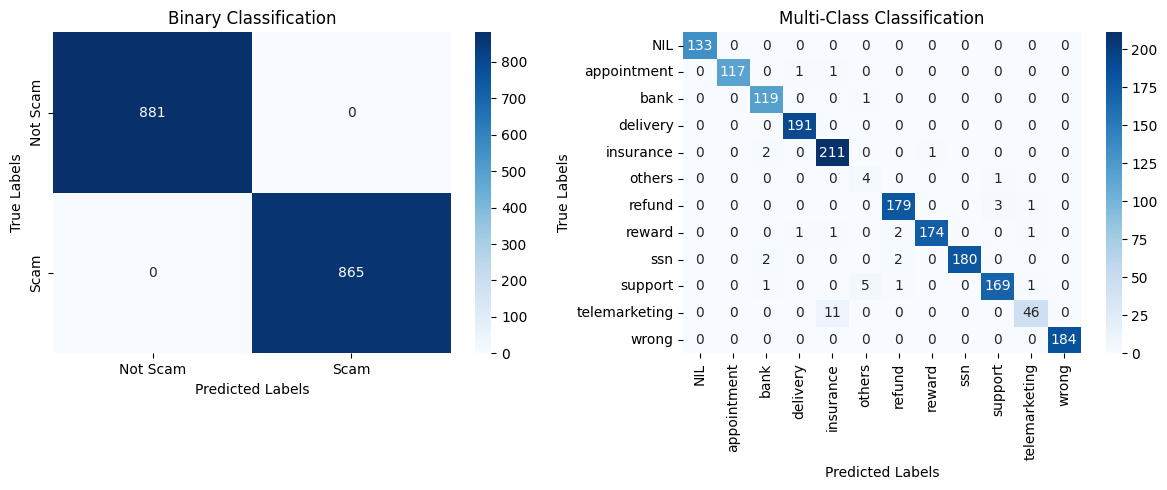

In [52]:
pred_label, pred_type = multi_task_model.predict(X_test)

eval_label, eval_type = multi_task_model.evaluate(X_test, y1_test, y2_test)

print("Test Set Metrics:")
print(f"Binary Classification:")
print(f"Accuracy: {eval_label[0]:.4f}")
print(f"Precision: {eval_label[1]:.4f}")
print(f"Recall: {eval_label[2]:.4f}")
print(f"F1 Score: {eval_label[3]:.4f}")

print("\nMulti-Class Classification:")
print(f"Accuracy: {eval_type[0]:.4f}")
print(f"Precision: {eval_type[1]:.4f}")
print(f"Recall: {eval_type[2]:.4f}")
print(f"F1 Score: {eval_type[3]:.4f}")

multi_task_model.plot_confusion_matrix(X_test, y1_test, y2_test, le.classes_)
